## Constant from IV-characteristics : <font color = 'sky blue'> $n_e, T_e, T_-, I_{sat+}$ </font>
<font size="2">
    [1] <a href="https://sci-hub.se/https://aip.scitation.org/doi/10.1063/1.4802252"> [2013] Langmuir probe analysis of highly electronegative plasmas</a> <br>
    [2] <a href="https://sci-hub.se/https://doi.org/10.1063/1.4903328"> [2014] Langmuir probe analysis in electronegative plasmas</a> <br>
    [3] <a href="https://sci-hub.se/https://doi.org/10.1063/1.874162"> [2000] How big is a small Langmuir probe?</a> <br>
    [4] <a href="https://sci-hub.se/10.1088/0022-3727/43/10/105204"> [2010] The plasma sheath around large discs and ion collection by planar Langmuir probes</a> <br>

In [32]:
import numpy as np
import xml.etree.ElementTree as ET
from scipy.optimize import fsolve
from scipy.integrate import simpson
from scipy.integrate import odeint
from const import *
import matplotlib.pyplot as plt
import ldfparser
import plotting

import importlib
importlib.reload(plotting)

<module 'plotting' from 'c:\\Users\\GUNU\\Desktop\\negative-ion\\plotting.py'>

In [41]:
class Iterative_method():
    def __init__(self, ne, Te, V_sat, I_sat, V_p):
        Tm = 0.1
        self.ne = ne
        self.Te = Te
        self.V_sat = V_sat
        self.I_sat = I_sat
        self.gamma = self.Te/Tm
        self.V_p = V_p
        self.De = np.sqrt(epsilon_0*kB*Te/(e**2*ne)) #electron debye length
        #print("ne : {:.2e}, Te : {}, V_sat : {}, I_sat : {:.2e}".format(ne,Te,V_sat,I_sat))
        
    def alpha_convert(self,a_0):
        def eqn21(a_s):
            return a_0 - a_s*np.exp(-1/2*(1+a_s)/(1+self.gamma*a_s)*(1-self.gamma))
        ans_arr = np.round(fsolve(eqn21,np.logspace(-2,2,5)),4)
        ans_arr = np.unique(ans_arr)
        a_s = min(ans_arr)
        print("a_0: {:.4f}\t a_s: {}\t gamma: {:.4f}\t sol_number: {}".format(a_0, a_s, self.gamma, len(ans_arr)))
        return a_s
    
    def modified_Bohm(self,a_s):
        uB = np.sqrt(e*self.Te/Mp)*np.sqrt((1+a_s)/(1+self.gamma*a_s))
        return uB
    
    def r_sh_calculation(self, J): 
            r_sh = np.sqrt(4/9*epsilon_0*np.sqrt(2*e/Mp)*(self.V_sat - self.V_p)**1.5/J)
            #r_sh = rp
            return r_sh
    
    def cal_rsh(self, V, J, a_s, uB):
        R = 20*rp
        def func(y, r):
            u, E = y
            dydr = [e*E/Mp/u, R*J/(epsilon_0*r*u)-E/r]
            return dydr
        y0 = [0, np.sqrt(2*e*(self.V_p-self.V_sat)/Mp + uB**2)]
        r1 = np.linspace(rp,R,100)
        sol = odeint(func, y0, r1)
        # plt.plot(r1, sol[:, 0] )
        # plt.plot(r1, sol[:, 1] )
        # plt.show()
        return simpson(sol[:, 1], r1) #V

    def iteration(self):
        #print("ne : {:.2e}, Te : {}, V_sat : {}, I_sat : {:.2e}".format(self.ne,self.Te,self.V_sat,self.I_sat))
        count = 0
        a_0 = 3
        r_sh_0 = rp
        S_eff = 2*(np.pi)*r_sh_0*lp
        
        while True:
            MAX_COUNT = 100
            count += 1
            a_s = self.alpha_convert(a_0)
            uB = self.modified_Bohm(a_s) # uB_k
            n_p = self.I_sat/(hr*S_eff*e*uB) # np_k , S_k-1
            comp = a_0 # for loop condition
            a_0 = n_p/self.ne-1 # a_0_k
            J = hr*e*n_p*uB # J_k
            #r_sh = self.r_sh_calculation(J) #r_sh_k
            #r_sh = self.cal_rsh(V, J, a_s, uB)
            r_sh = self.cal_rsh(V, J, a_s, uB)
            #r_sh = rp
            S_eff = 2*np.pi*r_sh*lp
            
            #print(count, a_0)
            
            if abs(comp - a_0) < 0.001*a_0:
                return a_0
                break
            if count == MAX_COUNT:
                print('-----------No Convergence!---------------------')
                break
        print('--------------------------------------------------')

In [42]:
def cal_sat(IV_df):
    V = np.array(IV_df['V'])
    I = np.array(IV_df['I'])
    return -V[0], -I[0]

def cal_Vp(IV_df):
    V = np.array(IV_df['V'])
    I = np.array(IV_df['I'])
    dIdV = np.gradient(I, V)
    Vp = V[np.argmax(dIdV)]
    return Vp

def cal_eepf(IV_df):
    Vp = cal_Vp(IV_df)
    V = np.array(IV_df['V'])
    I = np.array(IV_df['I'])
    
    I_adj = I[V<=Vp]
    V_adj = V[V<=Vp]-Vp
    dI = np.gradient(I_adj, V_adj)
    ddI = np.gradient(dI, V_adj)
    eepf = 2*ddI/e/Ap*np.sqrt(2*Me*(Vp-V_adj)/e)/np.sqrt(Vp-V_adj)
    eedf = 2*ddI/e/Ap*np.sqrt(2*Me*(Vp-V_adj)/e)
    return np.flip(-V_adj), np.flip(eepf), np.flip(eedf)

def cal_ne(V, eepf, V_lim):
    mask = V < V_lim
    eepf = eepf[mask]
    V = V[mask]
    return simpson(eepf, V)

def cal_Te(V, eedf, ne, V_lim):
    mask = V < V_lim
    eedf = eedf[mask]
    V = V[mask]
    return 2/3*simpson(eedf/ne*V, V)

In [43]:
#workDir = './211216(SF6)/bias (float) 0mm B-field/'
workDir = './211221(SF6)/SF6/B field scan_20V 0mm/'
parser = ldfparser.LDF(workDir)

no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/50.ldf


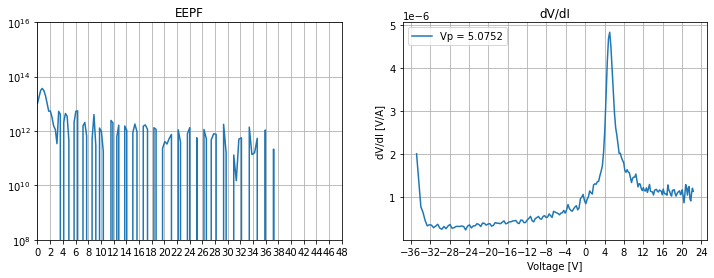

Enter limited energy
ne: 3.978e+13 [m-3]	 Te: 0.536 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.6716	 gamma: 5.3623	 sol_number: 1
nan
a_0: 7108.3745	 a_s: 4732.4709	 gamma: 5.3623	 sol_number: 1
nan
a_0: 8523.0639	 a_s: 5674.3803	 gamma: 5.3623	 sol_number: 1
nan
Vp: 5.07517, Vsat: 34.8019, Isat: 3.09005e-05


no eedf datas
./211221(SF6)/SF6/B field scan_20V 0mm/60.ldf


C:\Users\GUNU\AppData\Local\Temp/ipykernel_1960/1319989499.py:37: RuntimeWarning: invalid value encountered in sqrt
  y0 = [0, np.sqrt(2*e*(self.V_p-self.V_sat)/Mp + uB**2)]
C:\Users\GUNU\AppData\Local\Temp/ipykernel_1960/1319989499.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  dydr = [e*E/Mp/u, R*J/(epsilon_0*r*u)-E/r]
C:\Users\GUNU\anaconda3\envs\pyrl\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\GUNU\anaconda3\envs\pyrl\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Run terminated (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


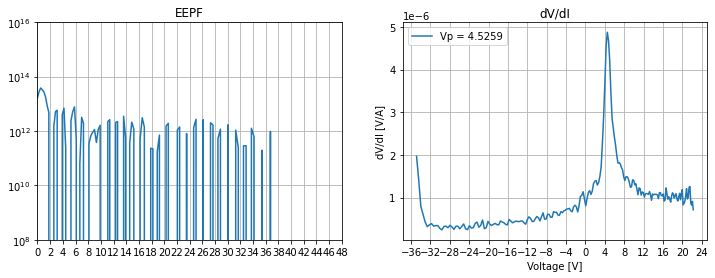

Enter limited energy


ValueError: could not convert string to float: ''

In [44]:
distances, nes, nms, alphas, Vps, Tes, Nis = [], [], [], [], [], [], []

ldf_files = parser.ldf_paths()
for file in ldf_files:
    IV, eedf, result = parser.pull_attr(file, need_return=True)
    print(file)
    distance = float(file.split('/')[-1][:-4])

    V = np.array(IV['V'])
    I = np.array(IV['I'])
    dIdV = np.gradient(I, V)
    Vsat, Isat = cal_sat(IV)
    Vp = cal_Vp(IV)
    my_V, my_eepf, my_eedf = cal_eepf(IV)
    #fig = plt.figure(figsize=(12, 6))
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].set_xticks(np.arange(0,50,2))
    ax[0].set_yscale('log')
    ax[0].grid(True)
    ax[0].set_title('EEPF')
    ax[0].set_xlim(0,)
    ax[0].set_ylim(1e8, 1e16)
    ax[0].plot(my_V, my_eepf)
    ax[1].set_xticks(np.arange(-40,40,4))
    ax[1].grid(True)
    ax[1].set_title('dV/dI')
    ax[1].set_ylabel('dV/dI [V/A]')
    ax[1].set_xlabel('Voltage [V]')
    ax[1].plot(V, dIdV)
    ax[1].legend(['Vp = {:.4f}'.format(Vp)])
    plt.show()
    print("Enter limited energy")
    V_lim = input()
    V_lim = np.float32(V_lim)
    ne = cal_ne(my_V, my_eepf, V_lim)
    Te = cal_Te(my_V, my_eepf, ne, V_lim)
    #ne = cal_ne_with_Vp(IV, Te)
    print('ne: {:.3e} [m-3]\t Te: {:.3f} [eV] \t V_lim: {}'.format(ne, Te, V_lim))
    
    exp = Iterative_method(ne,Te,Vsat,Isat,Vp)
    alpha = exp.iteration()
    nm = ne*alpha
    print("Vp: {}, Vsat: {}, Isat: {}\n\n".format(Vp, Vsat, Isat))
    
    Vps.append(Vp)
    alphas.append(alpha)
    nes.append(ne)
    nms.append(nm)
    distances.append(distance)
    Tes.append(Te)

Vps = np.array(Vps)
alphas = np.array(alphas)
nes = np.array(nes)
nms = np.array(nms)
distances = np.array(distances)
Tes = np.array(Tes)

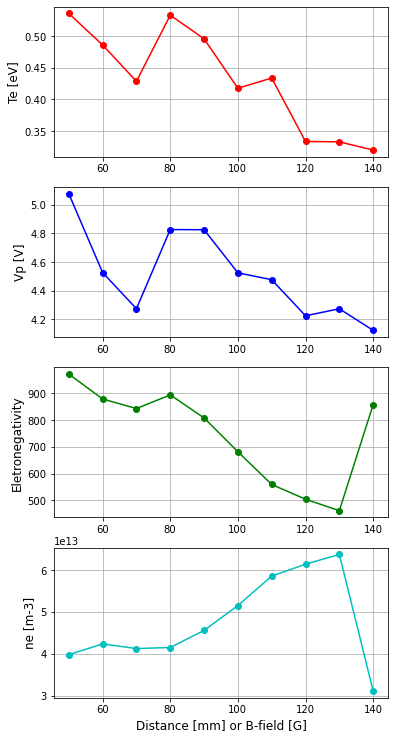

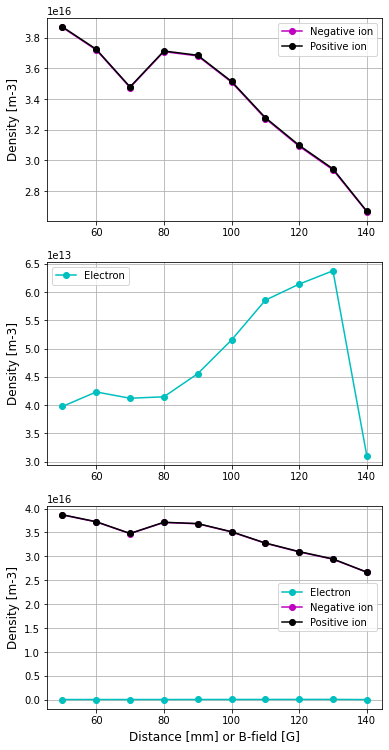

In [31]:
plotting.plot_default(distances, Tes, Vps, alphas, nes)
plotting.plot_density(distances, nes, nms, nes+nms)

The algorithm converged to the desired accuracy.


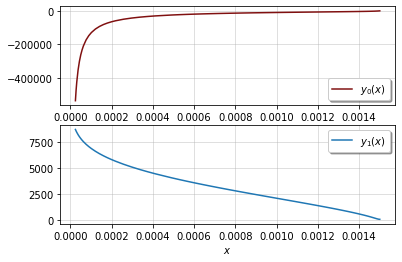

In [74]:
from scipy.integrate import solve_bvp
rp= 25e-6
J = 10
V = 50
uB = 100
R= 50e-5
def fun(r, y, r_sh):
    return np.vstack((r_sh*J/(r*epsilon_0*y[1])-y[0]/r, e*y[0]/(Mp*y[1])))

def bc(ya,yb,p):
    return np.array([yb[0],ya[1]-np.sqrt(2*e*V/Mp),yb[1]-uB])
# a=시작
# b=끝
# 0=E
# 1=u
n = 20
r = np.linspace(rp, 3*R, n)
y = np.array([np.linspace(V, 0, n)/(R-rp), np.linspace(np.sqrt(2*e*V/Mp), uB, n)])

sol = solve_bvp(fun, bc, r, y,p=(10*rp,))

if sol.status != 0:
    print("WARNING: sol.status is %d" % sol.status)
print(sol.message)

plt.subplot(2, 1, 1)
plt.plot(sol.x, sol.y[0], color='#801010', label='$y_0(x)$')
plt.grid(alpha=0.5)
plt.legend(framealpha=1, shadow=True)
plt.subplot(2, 1, 2)
plt.plot(sol.x, sol.y[1], '-', color='C0', label='$y_1(x)$')
plt.xlabel('$x$')
plt.grid(alpha=0.5)
plt.legend(framealpha=1, shadow=True)
plt.show()